# Pipeline Completo de Machine Learning para Predicción de Tiempos de Entrega

Este notebook demuestra el pipeline completo de machine learning para predecir tiempos de entrega de comida, utilizando los módulos desarrollados en `model_pipeline`. 

El notebook está organizado en los siguientes bloques principales:

1. **Importación de librerías y módulos**
2. **Carga y preparación de datos**
3. **Entrenamiento del modelo**
4. **Evaluación del modelo**
5. **Uso del modelo para predicciones**

---

## 1. Importar librerías y módulos necesarios

En este bloque importamos todas las librerías requeridas, incluyendo los módulos desarrollados en `model_pipeline` y las dependencias como pandas, numpy y scikit-learn.

In [1]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Librerías de machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Módulos del proyecto
import sys
import os
sys.path.append('../model_pipeline')

from data_preprocessing import DataPreprocessor
from model_training import DeliveryTimePredictor
from model_evaluation import ModelEvaluator
from prediction_service import DeliveryRequest, PredictionService
from utils.model_utils import ModelEvaluator as UtilsEvaluator, ModelSelector

print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✅ Librerías importadas correctamente
Pandas version: 2.3.0
NumPy version: 2.3.1
✅ Todos los módulos del pipeline importados exitosamente


## 2. Cargar y preparar los datos

En este bloque cargamos el dataset real de tiempos de entrega desde el archivo CSV ubicado en la carpeta `data/`.

In [2]:
# Cargar el dataset real de tiempos de entrega
data_path = '../data/Food_Delivery_Times.csv'
df = pd.read_csv(data_path)

print(f"✅ Dataset cargado exitosamente")
print(f"Forma del dataset: {df.shape}")
print(f"Columnas: {list(df.columns)}")

# Mostrar información básica del dataset
print("\n📊 Información del dataset:")
print(df.info())

print("\n📊 Estadísticas descriptivas:")
print(df.describe())

print("\n📊 Primeras 5 filas:")
df.head()

✅ Dataset cargado exitosamente
Forma del dataset: (1000, 9)
Columnas: ['Order_ID', 'Distance_km', 'Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type', 'Preparation_Time_min', 'Courier_Experience_yrs', 'Delivery_Time_min']

📊 Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


## 2.1. Análisis exploratorio básico

Vamos a hacer un análisis rápido de los datos para entender mejor su distribución y detectar posibles problemas.

🔍 Valores faltantes por columna:
Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64

🔍 Distribución de variables categóricas:

Weather:
Weather
Clear    470
Rainy    204
Foggy    103
Snowy     97
Windy     96
Name: count, dtype: int64

Traffic_Level:
Traffic_Level
Medium    390
Low       383
High      197
Name: count, dtype: int64

Time_of_Day:
Time_of_Day
Morning      308
Evening      293
Afternoon    284
Night         85
Name: count, dtype: int64

Vehicle_Type:
Vehicle_Type
Bike       503
Scooter    302
Car        195
Name: count, dtype: int64


🔍 Valores faltantes por columna:
Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64

🔍 Distribución de variables categóricas:

Weather:
Weather
Clear    470
Rainy    204
Foggy    103
Snowy     97
Windy     96
Name: count, dtype: int64

Traffic_Level:
Traffic_Level
Medium    390
Low       383
High      197
Name: count, dtype: int64

Time_of_Day:
Time_of_Day
Morning      308
Evening      293
Afternoon    284
Night         85
Name: count, dtype: int64

Vehicle_Type:
Vehicle_Type
Bike       503
Scooter    302
Car        195
Name: count, dtype: int64


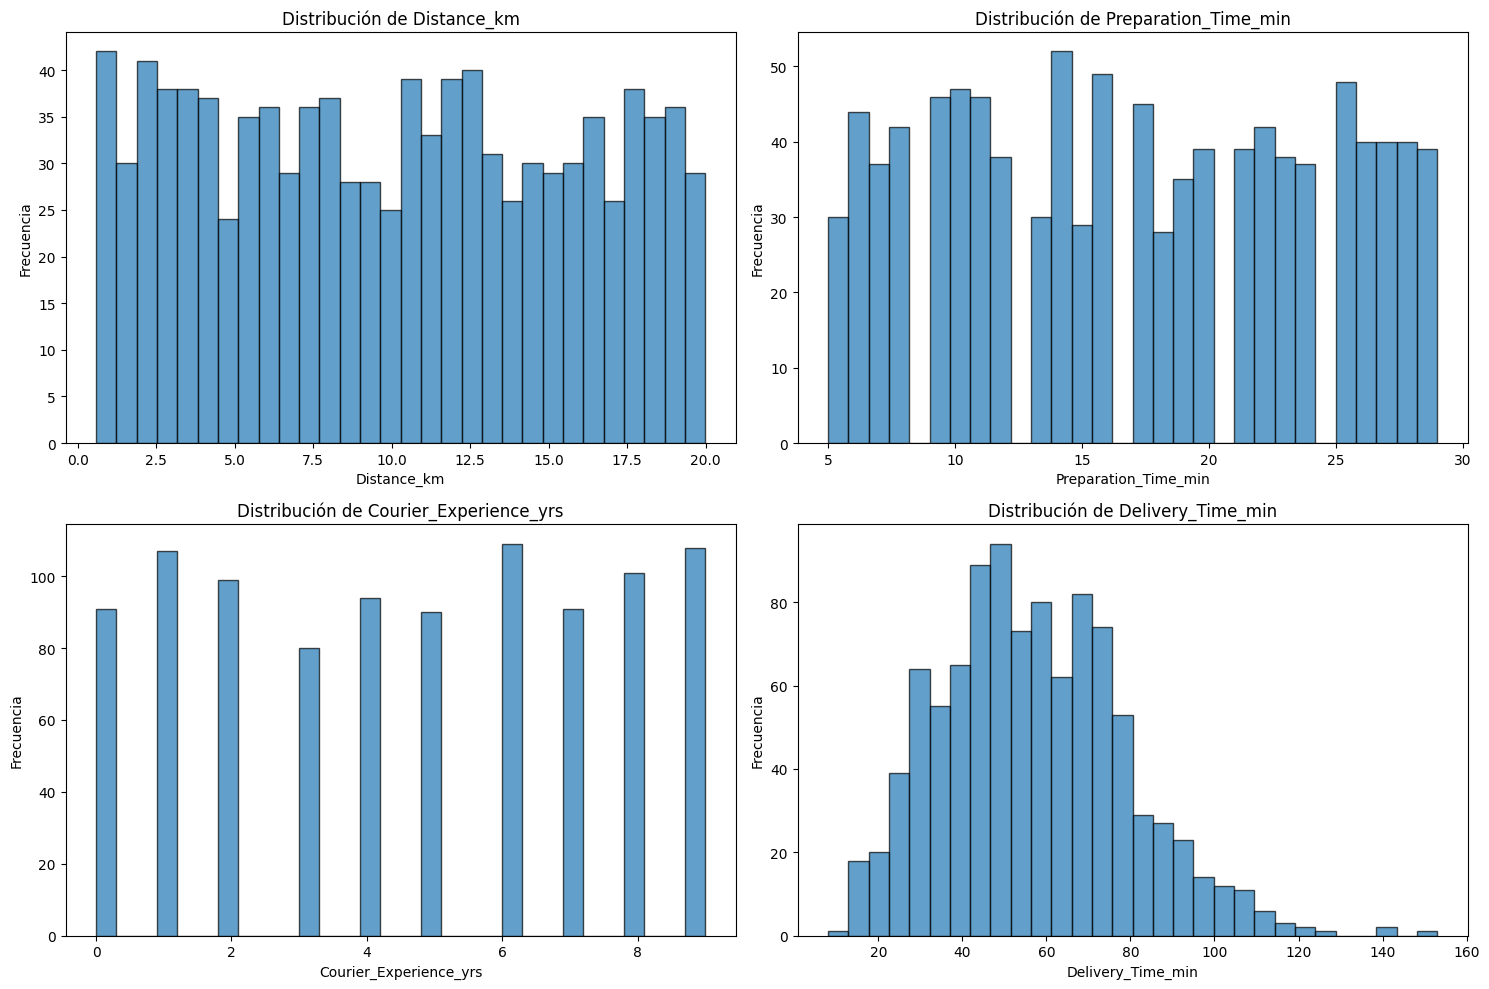

🔍 Valores faltantes por columna:
Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64

🔍 Distribución de variables categóricas:

Weather:
Weather
Clear    470
Rainy    204
Foggy    103
Snowy     97
Windy     96
Name: count, dtype: int64

Traffic_Level:
Traffic_Level
Medium    390
Low       383
High      197
Name: count, dtype: int64

Time_of_Day:
Time_of_Day
Morning      308
Evening      293
Afternoon    284
Night         85
Name: count, dtype: int64

Vehicle_Type:
Vehicle_Type
Bike       503
Scooter    302
Car        195
Name: count, dtype: int64


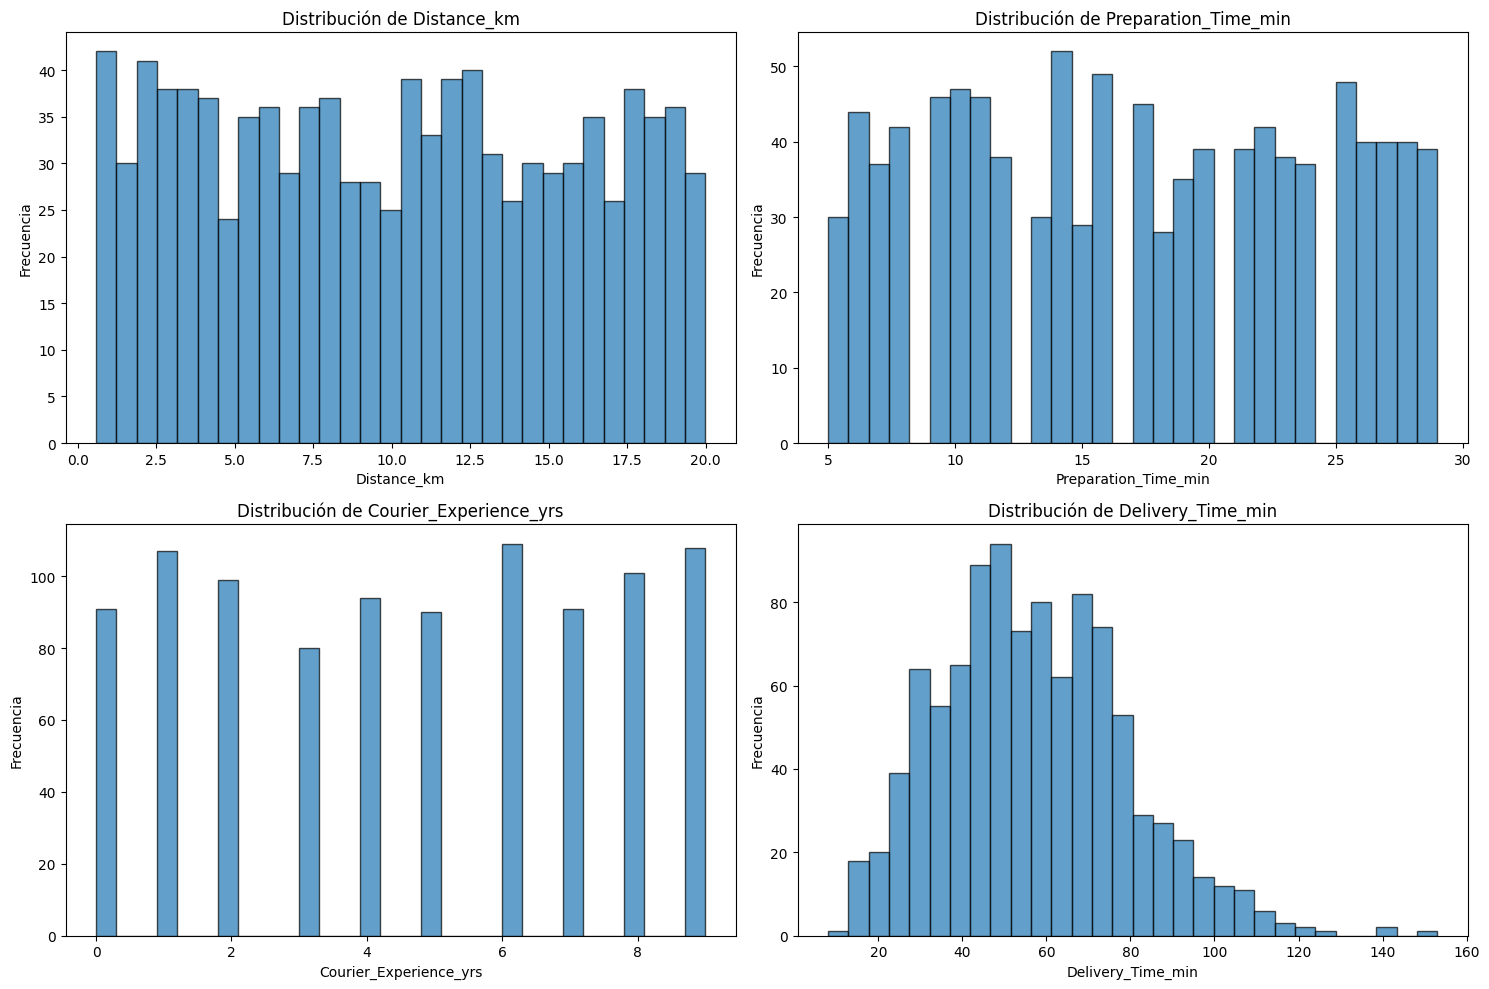

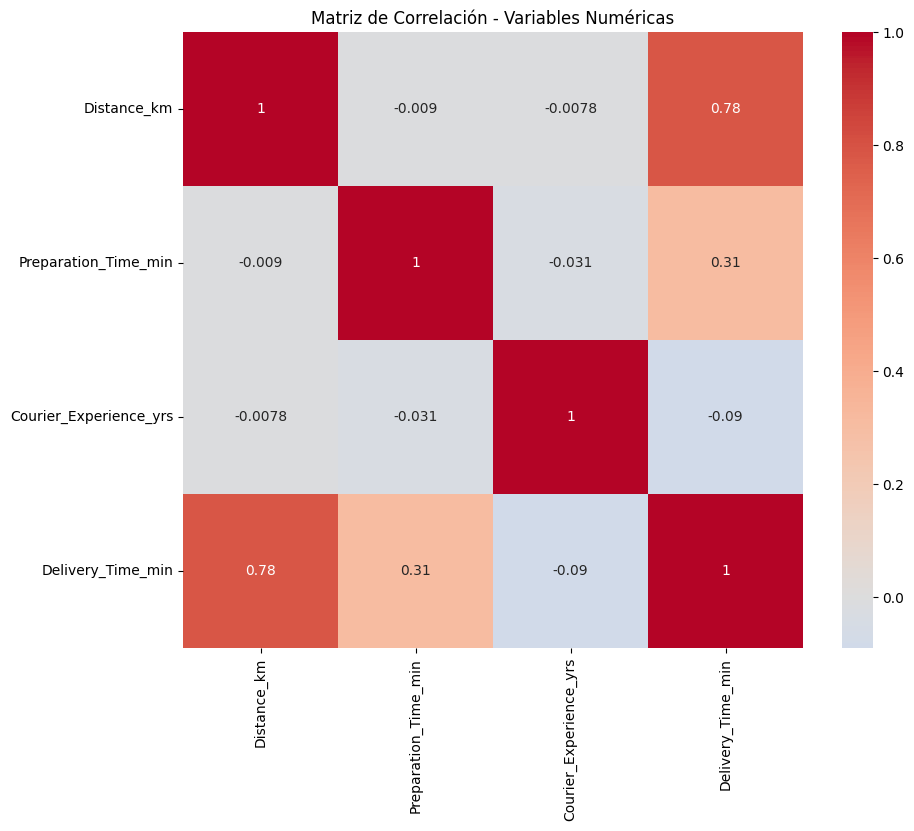


✅ Análisis exploratorio completado


In [3]:
# Verificar valores faltantes
print("🔍 Valores faltantes por columna:")
print(df.isnull().sum())

# Verificar distribución de variables categóricas
print("\n🔍 Distribución de variables categóricas:")
categorical_cols = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())

# Visualizar distribución de variables numéricas
plt.figure(figsize=(15, 10))
numeric_cols = ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs', 'Delivery_Time_min']

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    plt.hist(df[col], bins=30, alpha=0.7, edgecolor='black')
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Matriz de correlación para variables numéricas
plt.figure(figsize=(10, 8))
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación - Variables Numéricas')
plt.show()

print(f"\n✅ Análisis exploratorio completado")

## 3. Preprocesamiento de datos

En este bloque utilizamos la clase `DataPreprocessor` del módulo `model_pipeline` para preparar los datos para el entrenamiento del modelo.

In [8]:
# Configuración para el preprocesador
preprocessing_config = {
    'test_size': 0.2,
    'random_state': 42,
    'handle_outliers': True,
    'outlier_method': 'iqr',
    'outlier_factor': 1.5,
    'scale_target': False,
    'create_features': True
}

# Inicializar el preprocesador
preprocessor = DataPreprocessor(config=preprocessing_config)
print("⚙️ Iniciando preprocesamiento de datos...")
# Separar features y target
# Aplicamos el preprocesamiento a X_train
X_train, X_test, y_train, y_test = preprocessor.fit_transform(df)  # Ajustamos y transformamos los datos


print(f"\n✅ Preprocesamiento completado")
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de y_test: {y_test.shape}")

⚙️ Iniciando preprocesamiento de datos...
Features seleccionadas: ['Distance_km', 'Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type', 'Preparation_Time_min', 'Courier_Experience_yrs']
Forma de X: (1000, 7)
Forma de y: (1000,)


INFO:data_preprocessing:Starting data preprocessing...
INFO:data_preprocessing:Missing values found:
INFO:data_preprocessing:Weather                   30
Traffic_Level             30
Time_of_Day               30
Courier_Experience_yrs    30
dtype: int64
INFO:data_preprocessing:Found 6 outliers in Delivery_Time_min
INFO:data_preprocessing:Missing values found:
INFO:data_preprocessing:Weather                   30
Traffic_Level             30
Time_of_Day               30
Courier_Experience_yrs    30
dtype: int64
INFO:data_preprocessing:Found 6 outliers in Delivery_Time_min
INFO:data_preprocessing:Created features. New shape: (1000, 14)
INFO:data_preprocessing:Numerical features: ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs', 'Speed_kmh', 'Prep_to_Total_Ratio']
INFO:data_preprocessing:Categorical features: ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type', 'Experience_Level', 'Distance_Category', 'Weather_Traffic']
INFO:data_preprocessing:Preprocessing complete.

INFO:data_preprocessing:Starting data preprocessing...
INFO:data_preprocessing:Missing values found:
INFO:data_preprocessing:Weather                   30
Traffic_Level             30
Time_of_Day               30
Courier_Experience_yrs    30
dtype: int64
INFO:data_preprocessing:Found 6 outliers in Delivery_Time_min
INFO:data_preprocessing:Missing values found:
INFO:data_preprocessing:Weather                   30
Traffic_Level             30
Time_of_Day               30
Courier_Experience_yrs    30
dtype: int64
INFO:data_preprocessing:Found 6 outliers in Delivery_Time_min
INFO:data_preprocessing:Created features. New shape: (1000, 14)
INFO:data_preprocessing:Numerical features: ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs', 'Speed_kmh', 'Prep_to_Total_Ratio']
INFO:data_preprocessing:Categorical features: ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type', 'Experience_Level', 'Distance_Category', 'Weather_Traffic']
INFO:data_preprocessing:Preprocessing complete.


✅ Preprocesamiento completado
Forma de X_train: (800, 7)
Forma de X_test: (200, 7)
Forma de y_train: (800,)
Forma de y_test: (200,)


In [10]:
# Obtener información sobre las transformaciones aplicadas
if hasattr(preprocessor, 'get_feature_info'):
    feature_info = preprocessor.get_feature_info()
    print(f"\n📊 Información de features después del preprocesamiento:")
    print(f"Total de features: {len(feature_info) if feature_info else 'N/A'}")

INFO:data_preprocessing:Starting data preprocessing...
INFO:data_preprocessing:Missing values found:
INFO:data_preprocessing:Weather                   22
Traffic_Level             19
Time_of_Day               24
Courier_Experience_yrs    24
dtype: int64
INFO:data_preprocessing:Missing values found:
INFO:data_preprocessing:Weather                   22
Traffic_Level             19
Time_of_Day               24
Courier_Experience_yrs    24
dtype: int64


INFO:data_preprocessing:Starting data preprocessing...
INFO:data_preprocessing:Missing values found:
INFO:data_preprocessing:Weather                   22
Traffic_Level             19
Time_of_Day               24
Courier_Experience_yrs    24
dtype: int64
INFO:data_preprocessing:Missing values found:
INFO:data_preprocessing:Weather                   22
Traffic_Level             19
Time_of_Day               24
Courier_Experience_yrs    24
dtype: int64


KeyError: 'Delivery_Time_min'

## 4. Entrenamiento del modelo

En este bloque utilizamos la clase `DeliveryTimePredictor` para entrenar múltiples modelos y seleccionar el mejor.

In [ ]:
print("🚀 Iniciando entrenamiento de modelos...")
print("Esto puede tomar unos minutos dependiendo de la configuración...")

# Entrenar modelos
results = predictor.train_all_models(X_train, y_train)

print(f"\n✅ Entrenamiento completado")
print(f"Modelos entrenados: {list(results.keys()) if results else 'Error en entrenamiento'}")

## 5. Evaluación del modelo

En este bloque utilizamos la clase `ModelEvaluator` para realizar una evaluación exhaustiva del mejor modelo.

In [ ]:
# Inicializar el evaluador
evaluator = ModelEvaluator()

# Obtener el mejor modelo entrenado
print("\n🔍 Evaluando el mejor modelo...")
best_model = predictor.load_model()
best_model_name = predictor.best_model_name

if best_model is not None:
    print(f"📊 Evaluando el modelo: {best_model_name}")
    
    # Realizar predicciones
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Evaluación completa
    evaluation_results = evaluator.evaluate_model(
        y_true=y_test,
        y_pred=y_test_pred,
        model_name=best_model_name
    )
    
    print("\n📈 Métricas de evaluación:")
    if evaluation_results:
        for metric, value in evaluation_results.items():
            if isinstance(value, (int, float)):
                print(f"{metric}: {value:.4f}")
            else:
                print(f"{metric}: {value}")
    
    # Visualizar resultados
    plt.figure(figsize=(15, 5))
    
    # Gráfico 1: Valores reales vs predicciones
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_test_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.title('Valores Reales vs Predicciones')
    
    # Gráfico 2: Residuos
    plt.subplot(1, 3, 2)
    residuals = y_test - y_test_pred
    plt.scatter(y_test_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicciones')
    plt.ylabel('Residuos')
    plt.title('Gráfico de Residuos')
    
    # Gráfico 3: Distribución de residuos
    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Residuos')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Residuos')
    
    plt.tight_layout()
    plt.show()
    
    # Métricas adicionales
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    
    print(f"\n📊 Comparación Train vs Test:")
    print(f"MAE Train: {mae_train:.4f}")
    print(f"MAE Test: {mae_test:.4f}")
    print(f"Diferencia: {abs(mae_test - mae_train):.4f}")
    
    if abs(mae_test - mae_train) < 2:
        print("✅ El modelo parece estar bien generalizado")
    else:
        print("⚠️ Posible overfitting - revisar regularización")
        
else:
    print("❌ No hay modelo disponible para evaluar")

## 6. Uso del modelo para predicciones

En este bloque utilizamos la clase `PredictionService` para hacer predicciones con nuevos datos.

In [ ]:
# Inicializar el servicio de predicción
prediction_service = PredictionService(
    model=predictor.best_model,
    preprocessor=preprocessor
)

print("🎯 Inicializando servicio de predicción...")

# Crear algunos ejemplos de solicitudes de entrega
sample_requests = [
    DeliveryRequest(
        distance_km=5.2,
        weather="Clear",
        traffic_level="Medium",
        time_of_day="Evening",
        vehicle_type="Bike",
        preparation_time_min=15,
        courier_experience_yrs=3.5
    ),
    DeliveryRequest(
        distance_km=12.8,
        weather="Rainy",
        traffic_level="High",
        time_of_day="Afternoon",
        vehicle_type="Car",
        preparation_time_min=25,
        courier_experience_yrs=1.2
    ),
    DeliveryRequest(
        distance_km=2.1,
        weather="Snowy",
        traffic_level="Low",
        time_of_day="Morning",
        vehicle_type="Scooter",
        preparation_time_min=8,
        courier_experience_yrs=6.0
    )
]

print(f"\n🧪 Probando el modelo con {len(sample_requests)} ejemplos:")

# Hacer predicciones
for i, request in enumerate(sample_requests, 1):
    try:
        prediction = prediction_service.predict(request)
        
        print(f"\n--- Ejemplo {i} ---")
        print(f"Distancia: {request.distance_km} km")
        print(f"Clima: {request.weather}")
        print(f"Tráfico: {request.traffic_level}")
        print(f"Hora del día: {request.time_of_day}")
        print(f"Vehículo: {request.vehicle_type}")
        print(f"Tiempo de preparación: {request.preparation_time_min} min")
        print(f"Experiencia del repartidor: {request.courier_experience_yrs} años")
        
        if prediction:
            print(f"⏱️ Tiempo de entrega predicho: {prediction.get('prediction', 'N/A'):.1f} minutos")
            if 'confidence' in prediction:
                print(f"🎯 Confianza: {prediction['confidence']:.2f}")
        else:
            print("❌ Error en la predicción")
            
    except Exception as e:
        print(f"❌ Error procesando ejemplo {i}: {str(e)}")

print(f"\n✅ Demostración del pipeline completa")

## 7. Guardar el modelo entrenado

Finalmente, guardamos el modelo y el preprocesador para poder utilizarlos posteriormente.

In [ ]:
# Crear directorio para guardar modelos si no existe
model_save_path = '../models'
os.makedirs(model_save_path, exist_ok=True)

# Guardar el modelo y el preprocesador
if predictor.best_model is not None:
    try:
        # Guardar el modelo
        model_filename = f"{model_save_path}/best_delivery_model.pkl"
        joblib.dump(predictor.best_model, model_filename)
        print(f"✅ Modelo guardado en: {model_filename}")
        
        # Guardar el preprocesador
        preprocessor_filename = f"{model_save_path}/preprocessor.pkl"
        joblib.dump(preprocessor, preprocessor_filename)
        print(f"✅ Preprocesador guardado en: {preprocessor_filename}")
        
        # Guardar información del modelo
        model_info = {
            'model_name': predictor.best_model_name,
            'model_type': str(type(predictor.best_model).__name__),
            'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
            'features_used': feature_columns,
            'dataset_shape': df.shape,
            'test_metrics': evaluation_results if 'evaluation_results' in locals() else None
        }
        
        info_filename = f"{model_save_path}/model_info.json"
        import json
        with open(info_filename, 'w') as f:
            json.dump(model_info, f, indent=2, default=str)
        print(f"✅ Información del modelo guardada en: {info_filename}")
        
        print(f"\n🎉 Pipeline completado exitosamente!")
        print(f"📁 Archivos generados en: {model_save_path}/")
        print(f"   - best_delivery_model.pkl (modelo entrenado)")
        print(f"   - preprocessor.pkl (preprocesador)")
        print(f"   - model_info.json (información del modelo)")
        
    except Exception as e:
        print(f"❌ Error guardando el modelo: {str(e)}")
else:
    print("❌ No hay modelo para guardar")